In [10]:
import pyspark.sql.functions as F
from pyspark.sql.types import TimestampType
import datetime as dt
import pandas as pd
import pyspark.sql.types as st
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("whitegrid")
sc.setLogLevel("INFO")
udf = F.udf
%matplotlib inline

In [17]:
def count_addons(active_addons):
    """
    Given the Row of active_addons
    returns an integer indicating the number of active addons.

    Params:
    active_addons (col): spark Row of active addons

    Returns an integer indicating the number of addons
    """
    if active_addons is not None:
        return len(active_addons)
    else:
        return None

@udf(returnType=st.StringType())
def assign_branch(client_id):
    """
    Given the client_id compares with broadcasted sets of client_ids
    to return a branch assignment indicating the experimental branch 
    in which the client was observed.
    
    This is a UDF (see decorator)

    Params:
    cleint_id (string): spark Row containing the string cleint_id

    Returns an String  (eben if None) indicating the branch
    """
    if client_id in bc_ensemble_ids.value:
        return 'ensemble'
    elif client_id in bc_linear_ids.value:
        return 'linear'
    elif client_id in bc_control_ids.value:
        return 'control'
    else:
        return 'None'

### Data Prep

Load in cleaned experiment data, generated from [this notebook](https://github.com/mozilla/taar/blob/master/analysis/TAARExperimentV2Analysis.ipynb).

In [5]:
S3_PATH = "s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/cleaned_data/"
# Select essential columns.
clean_data = sqlContext.read.parquet(S3_PATH).select('client_id', 'locale', 'branch', 'submission_date_s3')

# Display number of rows per branch.
clean_data.groupBy('branch').count().collect()

[Row(branch=u'ensemble-taar', count=645481),
 Row(branch=u'control', count=2966556),
 Row(branch=u'linear-taar', count=661547)]

Grab the min and max submission dates for filtering `main_summary`.

In [6]:
min_date = clean_data.select(F.min('submission_date_s3').alias('min_d')).collect()[0].min_d
max_date = clean_data.select(F.max('submission_date_s3').alias('max_d')).collect()[0].max_d

print("min date: " + str(min_date))
print("max date: " + str(max_date))

min date: 20180312
max date: 20180423


Load in `main_summary`, filtered to the min date of the experiment, and (7 * N_WEEKS) days beyond its compleition (max_date) to allow for the specified n-week Retention Analysis. We then join `main_summary` with the experiment data.

In [7]:
# Get distinct client_ids that were observed in the TAAR experiment.
ensemble_ids = clean_data.rdd.filter(lambda p: p['branch'] == 'ensemble-taar').map(lambda x: x['client_id']).distinct()
linear_ids = clean_data.rdd.filter(lambda p: p['branch'] == 'linear-taar').map(lambda x: x['client_id']).distinct()
control_ids = clean_data.rdd.filter(lambda p: p['branch'] == 'control').map(lambda x: x['client_id']).distinct()

# Reduce redundant Rows to a set of client_ids per branch observed in TAAR.
local_ensemble_ids = set(ensemble_ids.collect())
local_linear_ids = set(linear_ids.collect())
local_control_ids = set(control_ids.collect())

# Sanity check that there are no elements in the set intersection between branches.
print(set.intersection(*[local_ensemble_ids, local_linear_ids, local_control_ids]))

# Broadcast the sets of ids for fast filtering on Main Summary.
bc_ensemble_ids = sc.broadcast(local_ensemble_ids)
bc_linear_ids = sc.broadcast(local_linear_ids)
bc_control_ids = sc.broadcast(local_control_ids)

# print(len(local_ensemble_ids))
# print(len(local_linear_ids))
# print(len(local_control_ids))

set([])


In [8]:
ms = (
    sqlContext.read.option("mergeSchema", True)
     .parquet("s3://telemetry-parquet/main_summary/v4")
     .filter("submission_date_s3 >= '{}'".format(min_date))
     .filter("normalized_channel = 'release'")
     .filter("app_name = 'Firefox'")
     .select('client_id', 'active_addons', 'locale', 'subsession_start_date', 'submission_date', 'submission_date_s3')
)

### Assign a branch label to each (client_id, submission_date) tuple
Filtering on non-None branches here ensures that the client was seen in the TAAR study since the broadcasted client_id sets are based on client data from the cleaned TAAr application logs.

In [47]:
# branches_col = ms.rdd.map(lambda p: (p['client_id'], count_addons(p['active_addons']), assign_branch(p['client_id']), p['submission_date_s3']))
branches_col = ms.withColumn("branch", assign_branch("client_id"))
branches_col = branches_col.filter(branches_col.branch != "None")
branches_col.take(1)

[Row(client_id=u'6f8f960b-0ea4-4d6f-a64e-a840807f99ec', active_addons=[Row(addon_id=u'followonsearch@mozilla.com', blocklisted=False, name=u'Follow-on Search Telemetry', user_disabled=False, app_disabled=False, version=u'0.9.7', scope=1, type=u'extension', foreign_install=False, has_binary_components=False, install_day=17568, update_day=17712, signed_state=None, is_system=True, is_web_extension=False, multiprocess_compatible=True), Row(addon_id=u'webcompat-reporter@mozilla.org', blocklisted=False, name=u'WebCompat Reporter', user_disabled=False, app_disabled=False, version=u'1.0.0', scope=1, type=u'extension', foreign_install=False, has_binary_components=False, install_day=17712, update_day=17712, signed_state=None, is_system=True, is_web_extension=False, multiprocess_compatible=True), Row(addon_id=u'webcompat@mozilla.org', blocklisted=False, name=u'Web Compat', user_disabled=False, app_disabled=False, version=u'2.0', scope=1, type=u'extension', foreign_install=False, has_binary_compon

In [30]:
# Double group by and count distinct shoudl leave us with a managable Pandas DF containing:
# datastring in %Y%m%d format (sortable), branch: {ensemble, linear, control} and distinct_client_count
# Everything we need for a day over day retetnion analysis for only clients observed in the TAAR study 
# spanning from the earliest study date to latest available ping.

df_daily_grouped = branches_col.groupby("submission_date_s3", "branch")
retention_pd = df_daily_grouped.agg(F.countDistinct('client_id')).toPandas()

+------------------+--------+-------------------------+
|submission_date_s3|  branch|count(DISTINCT client_id)|
+------------------+--------+-------------------------+
|          20180607|ensemble|                    44615|
|          20180316|  linear|                    84384|
|          20180523| control|                   359921|
|          20180329|ensemble|                    70929|
|          20180629| control|                   291919|
|          20180602|ensemble|                    36953|
|          20180426|ensemble|                    56175|
|          20180327| control|                   507139|
|          20180414|ensemble|                    50486|
|          20180627| control|                   307072|
|          20180423|  linear|                    57689|
|          20180331|ensemble|                    57680|
|          20180703| control|                   302356|
|          20180612|ensemble|                    43122|
|          20180624|  linear|                   

In [33]:
ret_df = retention_pd.sort('submission_date_s3', ascending=True)

/mnt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


### Calculate Retention Data

Perform day over day retention analysis.

In [34]:
ret_df.to_csv("taar_v2_retention-alternate.csv", index=False)

Write to s3 since this job is quite expensive and should only be run once.

In [36]:
%%bash
aws s3 cp taar_v2_retention-alternate.csv s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/

upload: ./taar_v2_retention-alternate.csv to s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention-alternate.csv


### Load processed Retention Data

This section loads the data generated above without having to the re-run the entire notebook.

In [37]:
%%bash 
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention-alternate.csv .

download: s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/taar_v2_retention-alternate.csv to ./taar_v2_retention-alternate.csv


In [44]:
ret = pd.read_csv("taar_v2_retention-alternate.csv")

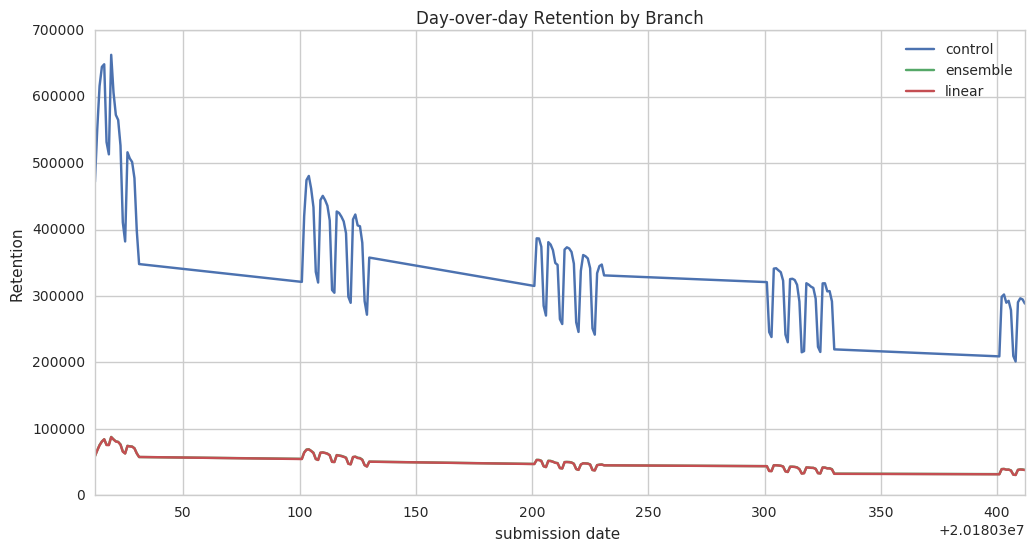

In [45]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
for group, data in ret.groupby("branch"):
    (data.sort_values("submission_date_s3")
         .plot(x='submission_date_s3', 
               y='count(DISTINCT client_id)', 
               ax=ax, 
               label=group))
plt.ylabel("Retention")
plt.xlabel("submission date ")
plt.title("Day-over-day Retention by Branch")
plt.show()

In [43]:
ret

,submission_date_s3,branch,count(DISTINCT client_id)
0,20180312,control,471767
1,20180312,ensemble,58857
2,20180312,linear,59086
3,20180313,control,551302
4,20180313,linear,67586
5,20180313,ensemble,67745
6,20180314,ensemble,75739
7,20180314,linear,75384
8,20180314,control,616198
9,20180315,linear,80920
